# Check uncertainty estimates


[can't start cudnn algorithm](https://stackoverflow.com/questions/53698035/failed-to-get-convolution-algorithm-this-is-probably-because-cudnn-failed-to-in)

In [1]:
# Extensions
%load_ext autoreload 

In [33]:
import os, sys, importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import seaborn as sns
from sklearn.model_selection import train_test_split


BASE_PATH = os.path.join(os.getcwd(), "..", "..")
MODULE_PATH = os.path.join(BASE_PATH, "modules")
DATASET_PATH = os.path.join(BASE_PATH, "datasets")

sys.path.append(MODULE_PATH)

from bayesian import McDropout, MomentPropagation
import data.mnist as mnist_loader

from data import BenchmarkData, DataSetType
import mp.MomentPropagation as mp

from models.default import default_model
from models.tf_growth import setup_growth

## Prepare Data

In [3]:
benchmark_data = BenchmarkData(DataSetType.MNIST, os.path.join(DATASET_PATH, "mnist"), classes=2)

In [4]:
benchmark_data.targets[:10]

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 0], dtype=uint8)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(benchmark_data.inputs, benchmark_data.targets)

In [6]:
unique_classes = np.unique(benchmark_data.targets)

def print_label_count(targets, unique_labels, prefix="train"):
    print(prefix + "_labels: ")
    
    for label in unique_labels:
        count = (targets==label).sum()
        print("Label-{}: {}".format(label, count))
    
    print("-------------")

print_label_count(y_train, unique_classes)
print_label_count(y_test, unique_classes)

train_labels: 
Label-0: 5208
Label-1: 5877
-------------
train_labels: 
Label-0: 1695
Label-1: 2000
-------------


## Train and build models

In [7]:
tf.random.set_seed(4)

In [8]:
setup_growth()

1 Physical GPU's,  1 Logical GPU's


In [9]:
model = default_model()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])

In [10]:
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
347/347 [==============================] - 6s 18ms/step - loss: 0.1469 - binary_accuracy: 0.9905
Epoch 2/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0117 - binary_accuracy: 0.9978
Epoch 3/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0092 - binary_accuracy: 0.9981
Epoch 4/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0093 - binary_accuracy: 0.9985
Epoch 5/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0068 - binary_accuracy: 0.9987
Epoch 6/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0036 - binary_accuracy: 0.9993
Epoch 7/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0041 - binary_accuracy: 0.9990
Epoch 8/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0022 - binary_accuracy: 0.9993
Epoch 9/100
347/347 [==============================] - 1s 4ms/step - loss: 3.3493e-05 - binary_accuracy: 1.0000
Epoch 10/100
347/347 [=

347/347 [==============================] - 1s 4ms/step - loss: 0.0053 - binary_accuracy: 0.9995
Epoch 76/100
347/347 [==============================] - 1s 4ms/step - loss: 1.0389e-11 - binary_accuracy: 1.0000
Epoch 77/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0153 - binary_accuracy: 0.9995
Epoch 78/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0233 - binary_accuracy: 0.9981
Epoch 79/100
347/347 [==============================] - 1s 4ms/step - loss: 9.3625e-04 - binary_accuracy: 0.9996
Epoch 80/100
347/347 [==============================] - 1s 4ms/step - loss: 2.6305e-04 - binary_accuracy: 0.9999
Epoch 81/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0541 - binary_accuracy: 0.9995
Epoch 82/100
347/347 [==============================] - 1s 4ms/step - loss: 0.0016 - binary_accuracy: 0.9996
Epoch 83/100
347/347 [==============================] - 1s 4ms/step - loss: 3.6019e-04 - binary_accuracy: 0.9996
Epoch 84/100
347

## Evaluate performance

In [10]:
model.evaluate(x_test, y_test)

116/116 [==============================] - 3s 22ms/step - loss: 6.8099 - binary_accuracy: 0.4606


[6.809908390045166, 0.4606224596500397]

Predicted label: [[0.00017951]]


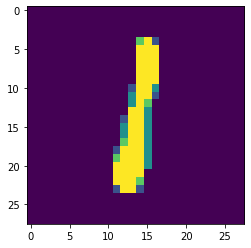

In [10]:
random_indx = np.random.choice(range(len(x_test)))

test_img = x_test[random_indx]
plt.imshow(test_img.reshape((28, 28)))

prediction = model(np.expand_dims(test_img, axis=0))

print("Predicted label: {}".format(prediction))

## Compare regular models

In [11]:
test_inputs = x_test[10:20]
test_targets = y_test[10:20]

test_targets

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0], dtype=uint8)

In [12]:
def check_shapes(inputs, targets):
    
    # Add batch dimension if single element given as 
    new_inputs = inputs
    if len(inputs.shape) == 3:
        new_inputs = np.expand_dims(inputs, axis=0)
        
    new_targets = targets
    if isinstance(test_targets, np.uint8):
        new_targets = np.array([targets])
    
    return new_inputs, new_targets

In [13]:
test_inputs, test_targets = check_shapes(test_inputs, test_targets)

In [14]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])
mp_model = MomentPropagation(model)

In [15]:
mp_result = mp_model.predict(test_inputs)
mp_result

[<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[7.89283004e-05],
        [1.94939602e-07],
        [6.12330157e-04],
        [5.79393491e-05],
        [6.45801338e-05],
        [1.19924352e-05],
        [2.42711599e-06],
        [1.16127346e-07],
        [1.13102456e-03],
        [1.84205373e-09]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[3.25818849e-03],
        [9.62930244e-06],
        [1.58093981e-02],
        [2.45260075e-03],
        [3.06777260e-03],
        [7.68493628e-04],
        [1.20901575e-04],
        [1.45117929e-05],
        [4.24505062e-02],
        [2.13192649e-07]], dtype=float32)>]

In [31]:
dp_model = McDropout(model)
dp_result = np.average(dp_model.predict(test_inputs, runs=50), axis=1)
dp_result

array([0.00603325, 0.01992328, 0.0020993 , 0.00665091, 0.01816636,
       0.00780493, 0.00272621, 0.00085167, 0.01451689, 0.00626744])

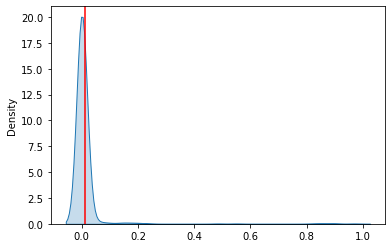

In [47]:
all_res = dp_model.predict(test_inputs, runs=1000)
sns.kdeplot(all_res[0], shade=True)
plt.axvline(np.mean(all_res, axis=1)[0], color='red')
plt.show()

In [17]:
def bar_plot(first_values, second_values, metrics=("MP", "DP"), ylabel="Max Entropy"):
    N = len(first_values)
    width = 0.35
    ind = np.arange(N)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    rects1 = ax.bar(ind, first_values, width)
    rects2 = ax.bar(ind+width, second_values, width)

    ax.set_ylabel(ylabel)

    ax.legend((rects1[0], rects2[0]), ("MP", "DP"))

In [18]:
test_targets

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0], dtype=uint8)

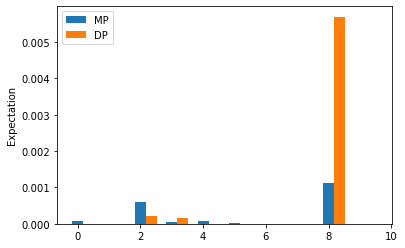

In [30]:
bar_plot(mp_result[0].numpy().flatten(), dp_result, ylabel="Expectation")

# Compare Max Entropy values

In [49]:
dp_model.predict(x_test[:2]).shape

(2, 1)
(10, 2, 1)


(2, 10)

In [20]:
# mc dropout max_entropy
%autoreload 2
mc_max_entropy = dp_model.get_query_fn("max_entropy")(x_test[10:20], runs=10)
mc_max_entropy

array([-3.44475682e-04,  3.80708307e-02, -6.65892819e-05,  7.12995948e-04,
       -9.89130178e-04,  1.66046937e-01,  6.68566335e-02, -2.88683946e-04,
        5.53516604e-02, -7.55468027e-04])

In [21]:
# moment propagation max entropy
%autoreload 2
mp_max_entropy = mp_model.get_query_fn("max_entropy")(x_test[10:20])
mp_max_entropy

array([-0.00038141, -0.00099796,  0.00354997, -0.00054465, -0.00049288,
       -0.00090481, -0.00098028, -0.00099863,  0.00708798, -0.00099953],
      dtype=float32)

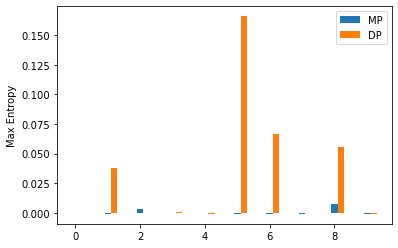

In [26]:
N = len(mc_max_entropy)
width = 0.2
ind = np.arange(N)

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, mp_max_entropy, width)
rects2 = ax.bar(ind+width, mc_max_entropy, width)

ax.set_ylabel("Max Entropy")
ax.legend((rects1[0], rects2[0]), ("MP", "DP"))

## Compare Max Var Ratios

In [27]:
%autoreload 2
dp_mvarr = dp_model.get_query_fn("max_var_ratio")(x_test[10:20], runs=10)
dp_mvarr

array([1.99684766, 1.9987057 , 1.98671453, 1.99170183, 1.99958135,
       1.9879807 , 1.99002438, 1.99940488, 1.97498435, 1.99955513])

In [28]:
mp_mvarr = mp_model.get_query_fn("max_var_ratio")(x_test[10:20])
mp_mvarr

array([7.8916550e-05, 1.7881393e-07, 6.1231852e-04, 5.7935715e-05,
       6.4551830e-05, 1.1980534e-05, 2.4437904e-06, 1.1920929e-07,
       1.1309981e-03, 0.0000000e+00], dtype=float32)

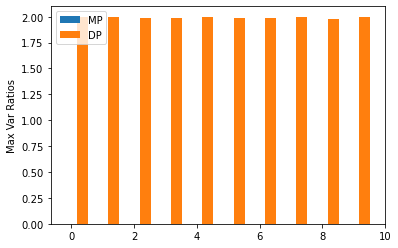

In [29]:
bar_plot(mp_mvarr, dp_mvarr, ylabel="Max Var Ratios")